# Gets summary of images in a directory

In [1]:
import os
import sys
from pathlib import Path
import pandas as pd
import geopandas as gpd
import numpy as np
import pyproj
import pickle
from shapely.geometry import box
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
sys.path.append(r"../LUCinSA_helpers")
from file_checks import *

In [10]:
'''
PARAMETERS: modify in notebook_params notebook, then run that notebook and this cell to update here
DO NOT modify this cell
'''

%store -r basic_config
print("Basic Parameters: \n brdf_dir = {} \n gridCell = {} \n index_dir = {} \n home_dir = {}"
      .format(basic_config['brdf_dir'],basic_config['grid_cell'],basic_config['index_dir'],basic_config['home_dir']))
%store -r single_output_params
print("SingleOutputParams: \n MapYears = {}".format(single_output_params['map_years']))
%store -r single_plot_params
print("SinglePlotParams: \n imageType = {}".format(single_plot_params['image_type']))

Basic Parameters: 
 brdf_dir = /home/sandbox-cel/paraguay_lc/stac/grid/003898/brdf 
 gridCell = 3898 
 index_dir = /home/downspout-cel/paraguay_lc/stac/grids/003898/brdf_ts/ms/evi2 
 home_dir = ~/data
SingleOutputParams: 
 MapYears = [2020, 2021]
SinglePlotParams: 
 imageType = AllRaw


In [11]:
###To get all images in brdf directory:
all_images = print_files_in_directory(basic_config['brdf_dir'],'.nc',print_list=basic_config['print_list'],out_dir=basic_config['home_dir'],data_source='stac')
#all_images = print_files_in_directory(Path('{}/{:06d}/landsat'.format(basic_config['raw_dir'],int(basic_config['grid_cell']))),'.tif',print_list=basic_config['print_list'],out_dir=basic_config['home_dir'],data_source='stac')

if basic_config['print_list'] == True:
    print('full dataframe is printed as FileList.txt in {}'.format(out_dir=basic_config['home_dir']))
else:
    print('sample of dataframe: (Not printed to file. Can print by setting printList=True in notebook_params)')
all_images.head(n=5)

sample of dataframe: (Not printed to file. Can print by setting printList=True in notebook_params)


,file,sensor,date,base,yr,yrmo
0,L3B_LE07_brdf22507602T1_20050422_20230730_C01_...,LE07,20050422,L3B_LE07_brdf22507602T1_20050422,2005,200504
1,L3A_LC08_brdf22507702T1_20140306_20230420_C01.nc,LC08,20140306,L3A_LC08_brdf22507702T1_20140306,2014,201403
2,L3B_S2A_brdf21KWP0L2A_20200329_20230420_C01_co...,S2A,20200329,L3B_S2A_brdf21KWP0L2A_20200329,2020,202003
3,L3B_LE07_brdf22507602T1_20110218_20230420_C01_...,LE07,20110218,L3B_LE07_brdf22507602T1_20110218,2011,201102
4,L3B_LT05_brdf22507602T1_20050820_20230730_C01_...,LT05,20050820,L3B_LT05_brdf22507602T1_20050820,2005,200508


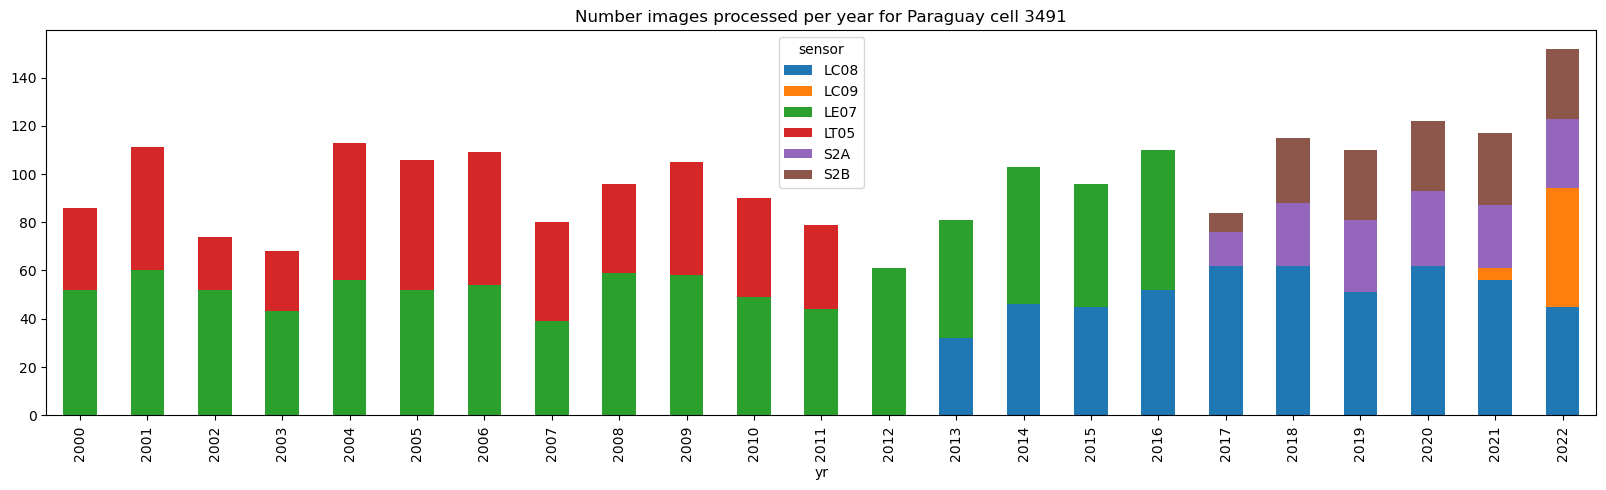

In [5]:
all_images.groupby(['yr','sensor']).size().unstack().plot(kind='bar', stacked=True, figsize=(20, 5), 
            title=('Number images processed per year for {} cell {}'.format(basic_config['country'],basic_config['grid_cell'])));

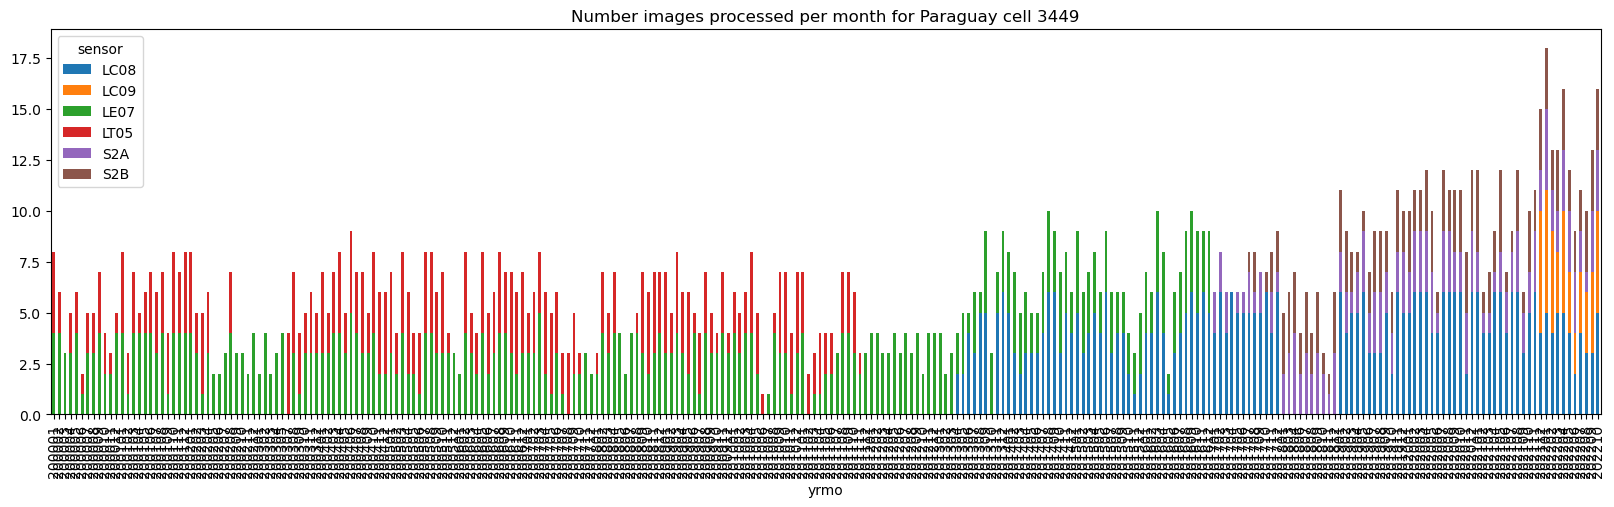

In [19]:
all_images.groupby(['yrmo','sensor']).size().unstack().plot(kind='bar', stacked=True, figsize=(20, 5), 
        title=('Number images processed per month for {} cell {}'.format(basic_config['country'],basic_config['grid_cell'])));

## Focus on smaller range of years to see month on axis:

In [ ]:
img_subset = all_images[all_images["yr"].astype(int) < 2011]
img_subset.groupby(['yrmo','sensor']).size().unstack().plot(kind='bar', stacked=True, figsize=(20, 5), 
   title=('Number images processed per month for {} cell {} from 2019 on'.format(basic_config['country'],basic_config['grid_cell'])));

## Read full downloading info file

In [ ]:
all_processing = "/raid-cel/r/downspout-cel/paraguay_lc/cell_processing_dl.csv"

## Read scene.info file

In [20]:
df = pd.read_pickle(Path('{}/{:06d}/{}/scene.info'.format(basic_config['raw_dir'],int(basic_config['grid_cell']),'landsat'.lower())))
print(len(df))
pd.DataFrame.to_csv(df, Path('{}/{:06d}_landsatList.csv'.format(basic_config['home_dir'],int(basic_config['grid_cell']))), sep=',', na_rep='.', index=False) 

1693


In [21]:
brdf_df = pd.read_pickle(Path('{}/scene.info'.format(basic_config['brdf_dir'],int(basic_config['grid_cell']))))
#brdf_df.set_index('id',drop=True,inplace=True)
#brdf_df.rename(columns={'out_id':'brdf_id','error':'brdf_error'},inplace=True)
brdf_df.tail(n=15)

,id,out_id,date,sensor,brdf,bandpass,error
1708,LC08_L2SP_226077_20171015_02_T1,L3A_LC08_brdf22607702T1_20171015_20231127_C01.nc,2017-10-15,lc08,True,False,None
1709,LC08_L2SP_226078_20171015_02_T1,L3A_LC08_brdf22607802T1_20171015_20231127_C01.nc,2017-10-15,lc08,True,False,None
1710,LC08_L2SP_227077_20171022_02_T1,L3A_LC08_brdf22707702T1_20171022_20231127_C01.nc,2017-10-22,lc08,True,False,None
1711,LC08_L2SP_226077_20171031_02_T1,L3A_LC08_brdf22607702T1_20171031_20231127_C01.nc,2017-10-31,lc08,True,False,None
1712,LC08_L2SP_226078_20171031_02_T1,L3A_LC08_brdf22607802T1_20171031_20231127_C01.nc,2017-10-31,lc08,True,False,None
1713,LC08_L2SP_227077_20171107_02_T1,L3A_LC08_brdf22707702T1_20171107_20231127_C01.nc,2017-11-07,lc08,True,False,None
1714,LC08_L2SP_226077_20171116_02_T1,L3A_LC08_brdf22607702T1_20171116_20231127_C01.nc,2017-11-16,lc08,True,False,None
1715,LC08_L2SP_226078_20171116_02_T1,L3A_LC08_brdf22607802T1_20171116_20231127_C01.nc,2017-11-16,lc08,True,False,None
1716,LC08_L2SP_227077_20171123_02_T1,L3A_LC08_brdf22707702T1_20171123_20231127_C01.nc,2017-11-23,lc08,True,False,None
1717,LC08_L2SP_226078_20171202_02_T1,L3A_LC08_brdf22607802T1_20171202_20231127_C01.nc,2017-12-02,lc08,True,False,None


In [12]:
p_df = pd.read_pickle(Path('{}/{:06d}/processing.info'.format(basic_config['raw_dir'],int(basic_config['grid_cell']))))
#processing_db = p_df.rename_axis(None,axis=1,inplace=True)
#pdict = p_df.to_dict(orient='index')
#new_processing_info = pd.DataFrame.from_dict(pdict,orient='index')
#new_processing_info.rename_axis('id', axis=1, inplace=True)
#pd.to_pickle(new_processing_info, os.path.join(basicConfig['out_dir'],'processing_db'))

#p_df_skip = p_df[p_df['skip'] == True]
p_df.tail()
#match = p_df.loc[p_df.index.str.contains('2007', na = False)]
#p_df.index = p_df.index.set_names(['id'])
#p_df.reset_index(drop=False, inplace=True)
#p_df.head(n=50)
#print(len(p_df))

id,dl,beforeDB,dldate,numpix,redownload,error,skip,skip_reason,brdf_id,brdf_error,brdf,bandpass,coreg,shift_x,shift_y,coreg_error
LE07_L2SP_225076_20050812_02_T1,/raid-cel/sandbox/sandbox-cel/paraguay_lc/stac...,False,2023-07-27,3073615.0,False,NaN,False,NaN,L3B_LE07_brdf22507602T1_20050812_20230730_C01.nc,None,True,True,True,-0.024919,-0.065186,NaN
LT05_L2SP_225077_20050820_02_T1,/raid-cel/sandbox/sandbox-cel/paraguay_lc/stac...,False,2023-07-27,3556749.0,False,NaN,False,NaN,L3B_LT05_brdf22507702T1_20050820_20230730_C01.nc,None,True,True,True,0.161186,-0.089258,NaN
LT05_L2SP_225076_20050820_02_T1,/raid-cel/sandbox/sandbox-cel/paraguay_lc/stac...,False,2023-07-27,4026884.0,False,NaN,False,NaN,L3B_LT05_brdf22507602T1_20050820_20230730_C01.nc,None,True,True,True,-0.084071,0.147214,NaN
LE07_L2SP_225077_20050828_02_T1,/raid-cel/sandbox/sandbox-cel/paraguay_lc/stac...,False,2023-07-27,2886114.0,False,NaN,False,NaN,L3B_LE07_brdf22507702T1_20050828_20230730_C01.nc,None,True,True,True,0.220697,0.166768,NaN
LE07_L2SP_225076_20050828_02_T1,/raid-cel/sandbox/sandbox-cel/paraguay_lc/stac...,False,2023-07-27,3071089.0,False,NaN,False,NaN,L3B_LE07_brdf22507602T1_20050828_20230730_C01.nc,None,True,True,True,0.221652,0.171789,NaN


In [8]:
##for all years:
#dfAll = get_img_list_from_db(SinglePlotParams['imageType'], basicConfig['raw_dir'], basicConfig['gridCell'],yrs=None,data_source='stac')
##for selection of years:
dfSlice = get_img_list_from_db(basic_config['brdf_dir'], basic_config['grid_cell'],single_plot_params['image_type'],yrs=single_output_params['map_years'],data_source='stac')
dfSlice.head(5)

KeyError: '2020-01-01:2021-12-31'

In [ ]:
CatList = get_img_list_from_cat(single_plot_params['image_type'],basic_config['grid_cell'], basic_config['grid_file'], yrs=single_output_params['map_years'])

In [11]:
missing_files = compare_files_to_db(single_plot_params['image_type'], 'Both', basic_config['raw_dir'], basic_config['grid_cell'], basic_config['grid_file'], yrs=single_output_params['map_years'],data_source=basic_config['data_source'])

Checking files against local database for 2020-2021...


TypeError: int() argument must be a string, a bytes-like object or a number, not 'PosixPath'

## Check processing for cell

In [ ]:
get_cell_status(basic_config['raw_dir'],basic_config['grid_cell'],basic_config['grid_file'],yrs = [2010,2022])

##TO ADD:
    ##Check if brdfs have been generated
    ## if yes, check for...
    ##Check coreg
      ##check non-coreged images
    ##Check indices

In [ ]:
#catfiff = ComparePlanetaryHub_w_Element84 ('Sentinel', basicConfig['gridCell'],basicConfig['gridFile'],Yrs = [2010,2022])
diff0 = pd.DataFrame(catdiff[0])
diff0['date'] = diff0.apply(lambda x: x[0].split("_")[2], axis=1)
diff0.sort_values(by=['date'], inplace=True) 
diff1 = pd.DataFrame(catdiff[1])
diff1['date'] = diff1.apply(lambda x: x[0].split("_")[2], axis=1)
diff1.sort_values(by=['date'], inplace=True)    
print('{} Images in Element84 but not Planetary: {}'.format(len(catdiff[0]),diff0))
print('{} Images in Planetary but not Element84: {}'.format(len(catdiff[1]),diff1))

## Check original products

In [ ]:
l_orig = get_img_from_planetary_hub(catlist[0])
import rich.table

table = rich.table.Table("Asset Key", "Descripiption")
for asset_key, asset in l_orig.assets.items():
    # print(f"{asset_key:<25} - {asset.title}")
    table.add_row(asset_key, asset.title)

table

In [ ]:
#get url to download a band/asset:
url=img.assets["nir08"].href
print(url)

# Get cell status from new db

In [ ]:
##for all years:
#dfAll = GetImgListFromDb(basicConfig['raw_dir'], basicConfig['gridCell'],SinglePlotParams['imageType'],Yrs=None,dataSource='stac')
##for selection of years:
dfSlice = get_img_list_from_db(basic_config['raw_dir'], basic_config['grid_cell'],single_plot_params['image_type'],yrs=single_output_params['map_years'],data_source='stac')

dfSlice.head(n=5)

In [ ]:
(note, there are some methods in file_checks.py to get status of single (and all cells -- but this is done in notebook 5). Most were written before this db was created. Need to consolidate & finish processing checks.

## To save an html copy of this notebook with all outputs:

In [ ]:
### Run to print output as html
out_name = str(basic_config['country']+'1a_ImagesProcessed_in_Cell_'+str(basic_config['grid_cell']))
!jupyter nbconvert --output-dir='./Outputs' --to html --no-input --output=$out_name 1a_ExploreData_FileContent.ipynb